# Settings

In [1]:
# prompt: count number of nested images in a folder using pathlib

import pathlib

# Create a pathlib.Path object for the directory you want to count images in
data_dir = pathlib.Path(r"data\CIRR\img_raw\train")

# Use the glob method to find all files ending in .jpg
images = data_dir.glob("**/*.png")

# Count the number of images
num_images = len(list(images))

# Print the number of images
print(f"Number of images: {num_images}")

Number of images: 16939


In [2]:
indexes = None # global var stores indexed vectors of train, val, test set.

In [3]:
import torch
from src.model.clip import load
from src.model.model import IM2TEXT
from src.third_party.open_clip.clip import _transform, tokenize
from src.utils import convert_models_to_fp32

from src.dataset import CIRR, CIRRImageSplit
from torch.utils.data import DataLoader
import faiss
from tqdm import tqdm
from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import json

In [4]:
def show_images(img_list):  # list(tuple(image, title))
    num_img = len(img_list)
    figsize = num_img * 10

    plt.figure(figsize=(figsize, figsize))

    for i in range(num_img):
        img, title = img_list[i]

        plt.subplot(1, num_img, i + 1)
        plt.title(title)

        # Convert pil image to numpy array
        img = np.array(img)

        # Resize the image to a fixed size
        img = cv.resize(img, (300, 300))

        # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        cmap = None if len(img.shape) == 3 else "gray"
        img = plt.imshow(img, cmap, interpolation="bicubic")
        plt.axis("off")

In [5]:
ckpt_path = "./checkpoints/pic2word_model.pt"

checkpoint = torch.load(ckpt_path)

# CLIP Model

In [6]:
clip_model, preprocess_train, preprocess_val = load(name="ViT-L/14", jit=False)

In [7]:
convert_models_to_fp32(clip_model)

In [8]:
clip_model = clip_model.cuda()

clip_sd = checkpoint["state_dict"]
clip_sd = {k[len("module.") :]: v for k, v in clip_sd.items()}  # strip the names
clip_model.load_state_dict(clip_sd)

<All keys matched successfully>

# Mapping Network

In [9]:
img2text = IM2TEXT(
    embed_dim=clip_model.embed_dim,
    output_dim=clip_model.token_embedding.weight.shape[1],
)

In [10]:
img2text = img2text.cuda()

i2t_sd = checkpoint["state_dict_img2text"]
i2t_sd = {
    k[len("module.") :]: v for k, v in i2t_sd.items()
}  # strip the names
img2text.load_state_dict(i2t_sd)

<All keys matched successfully>

# Dataset


In [12]:
cirr = CIRR(transforms=preprocess_val, root="./data", mode="caps", vis_mode=True)

Loading json data from ./data\CIRR\captions/cap.rc2.val.json
Use 2206 imgs


In [13]:
dl = DataLoader(
    cirr,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

len(dl)

2206

In [14]:
batch, label = next(iter(dl))

In [15]:
batch.shape, len(label)

(torch.Size([1, 3, 224, 224]), 1)

In [16]:
# this dataset is used for collection indexing
cirr_test_split = CIRRImageSplit(
    transforms=preprocess_val, root="./data", split="test"
)

test_dl = DataLoader(
    cirr_test_split,
    batch_size=32,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

f'Number of batches: {len(test_dl)}'

Loading json data from data\CIRR\image_splits\split.rc2.test1.json
Use 2315 imgs


'Number of batches: 73'

In [11]:
cirr_dev_split = CIRRImageSplit(
    transforms=preprocess_val, root="./data", split="val"
)

val_dl = DataLoader(
    cirr_dev_split,
    batch_size=8,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

f'Number of batches: {len(val_dl)}'

Loading json data from data\CIRR\image_splits\split.rc2.val.json
Use 2297 imgs


'Number of batches: 288'

In [23]:
img_batch, img_key = next(iter(val_dl))

img_batch.shape, len(img_key)

(torch.Size([8, 3, 224, 224]), 8)

In [16]:
cirr_train_split = CIRRImageSplit(
    transforms=preprocess_val, root="./data", split="train"
)

train_dl = DataLoader(
    cirr_train_split,
    batch_size=4,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

f'Number of batches: {len(train_dl)}'

Loading json data from data\CIRR\image_splits\split.rc2.train.json
Use 16939 imgs


'Number of batches: 4235'

# Dummy inference

In [16]:
# encode image

with torch.no_grad():
    image_features = clip_model.encode_image(batch.cuda())

print(image_features.shape)

torch.Size([1, 768])


In [17]:
# map visual features to text features

with torch.no_grad():
    query_img_feat = img2text(image_features)

print(query_img_feat.shape)

torch.Size([1, 768])


In [19]:
# tokenize the prompt

def process_prompt(prompt):
    text = []

    for p in prompt:
        text_tokens = tokenize(p)
        text.append(text_tokens)
    text = torch.cat(text, dim=0)
    return text

In [20]:
text = "A photo of * with a caption of a bird."

text = process_prompt([text])

text = text.cuda()

text.shape

torch.Size([1, 77])

In [21]:
# compose text with visual features
split_id = tokenize(["*"])[0][1]

with torch.no_grad():
    composed_feature = clip_model.encode_text_img_retrieval(
        text, query_img_feat, split_ind=split_id
    )

In [22]:
composed_feature.shape

torch.Size([1, 768])

# Collection Indexing

In [17]:
def normalize(x):
    return x / x.norm(dim=-1, keepdim=True)

## Use pytorch dot product

In [19]:
# all_img_features = torch.zeros(1, 768)

# with tqdm(total=len(train_dl)) as pbar:
#     for batch, _ in train_dl:
#         with torch.no_grad():
#             image_features = clip_model.encode_image(batch.cuda())
#             image_features = normalize(image_features)
#             all_img_features = torch.cat((all_img_features, image_features.cpu()), dim=0)
#         pbar.update(1)

# all_img_features = all_img_features[1:]

# torch.save(all_img_features, 'data\indexes\cirr_train.torch.index')

 16%|█▌        | 663/4235 [7:52:56<42:27:59, 42.80s/it]    


KeyboardInterrupt: 

In [ ]:
# all_img_features = torch.load('data\indexes\cirr_train.torch.index')

# all_img_features.shape

torch.Size([2297, 768])

## Use Faiss

In [ ]:
# Create a IP index
# index = faiss.IndexFlatIP(clip_model.embed_dim)

In [ ]:
# index.add(all_img_features.numpy())

# print(index.ntotal)

# # Save the index
# faiss.write_index(index, "data\indexes\cirr_train.faiss.index")

2297


In [ ]:
# # Indexing
# with tqdm(total=len(val_dl)) as pbar:
#     for batch, key in val_dl:
#         with torch.no_grad():
#             image_features = clip_model.encode_image(batch.cuda())
#             image_features = normalize(image_features)
#             index.add(image_features.cpu().numpy())
#         pbar.update(1)

In [ ]:
# write index to disk
# faiss.write_index(index, 'data/indexes/cirr_train.faiss.index')

In [30]:
# read index from disk
index = faiss.read_index("data/indexes/cirr_val.faiss.index")

# number of indexed vectors
index.ntotal

2297

# Retrieval

In [ ]:
view_ds = CIRRImageSplit(transforms=None, root="./data", split="test")

Loading json data from data/CIRR/image_splits/split.rc2.test1.json
Use 2315 imgs


In [ ]:
def index_to_key(indexes):
    return [str(view_ds.target_imgs[idx]) for idx in indexes]

In [ ]:
# def vector_search(query_feature, top_k = 5):
#   similarity = all_img_features @ query_feature.T
#   sim, indices = torch.sort(similarity, descending=True, dim=0)
#   return sim[:top_k].reshape(-1), indices[:top_k].reshape(-1)

def vector_search(query_feature, top_k = 5):
  assert indexes != None
  D, I = indexes.search(query_feature.numpy(), top_k)
  return D[0], I[0]

In [ ]:
def retrieve(ref_img, caption, top_k=5):
    img = preprocess_val(ref_img).unsqueeze(0)
    text = process_prompt([caption])

    img, text = img.cuda(), text.cuda()

    with torch.no_grad():
        image_features = clip_model.encode_image(img)
        query_img_feat = img2text(image_features)
        composed_feature = clip_model.encode_text_img(
            text, query_img_feat
        )
        composed_feature = normalize(composed_feature)
        D, I = vector_search(composed_feature.cpu(), top_k)

    return I, D

In [ ]:
caption = "A photo of *, shows two dogs eating."

ref_img_key = "data/CIRR/img_raw/test1/test1-83-1-img1.png"

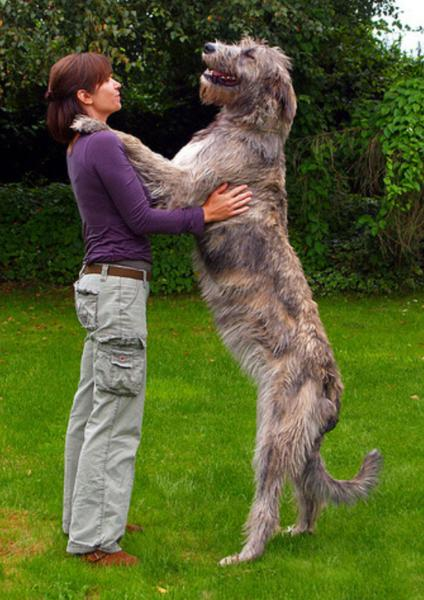

In [ ]:
ref_img = Image.open(ref_img_key, mode="r")

ref_img

In [ ]:
result_idx, _ = retrieve(ref_img, caption, top_k=10)

result_idx

array([   1, 2226,    3, 1232,  922,    2,    0, 1173, 2234, 2079])

In [ ]:
result_imgs = [view_ds[idx][0] for idx in result_idx]

shown_imgs = []

for i, ref_img in enumerate(result_imgs):
    shown_imgs.append((ref_img, f"Result {i}"))

show_images(shown_imgs)

Output hidden; open in https://colab.research.google.com to view.

# Evaluation on test set

In [ ]:
test_annotation = pd.read_json("./data/CIRR/captions/cap.rc2.test1.json")

test_annotation.head()

,pairid,reference,caption,img_set
0,12063,test1-147-1-img1,remove all but one dog and add a woman hugging it,"{'id': 1, 'members': ['test1-147-1-img1', 'tes..."
1,12064,test1-83-0-img1,mirror the image,"{'id': 1, 'members': ['test1-147-1-img1', 'tes..."
2,12065,test1-83-1-img1,shows two dogs eating,"{'id': 1, 'members': ['test1-147-1-img1', 'tes..."
3,12066,test1-1003-2-img1,change to a man standing and a girl sitting on...,"{'id': 3, 'members': ['test1-70-0-img1', 'test..."
4,12069,test1-1049-1-img0,Unlike the reference image that shows glass do...,"{'id': 69, 'members': ['test1-131-2-img1', 'te..."


In [ ]:
test_annotation.shape

(4148, 4)

In [ ]:
test_result = {"version": "rc2", "metric": "recall"}

for i in tqdm(range(len(test_annotation))):
    ref_img_key = test_annotation.iloc[i]["reference"]
    caption = test_annotation.iloc[i]["caption"]
    pairid = test_annotation.iloc[i]["pairid"]

    ref_img = Image.open(f"data/CIRR/img_raw/test1/{ref_img_key}.png", mode="r")

    result_idx, _ = retrieve(ref_img, f'A photo of * , {caption}', top_k=50)

    test_result[str(pairid)] = index_to_key(result_idx)

100%|██████████| 4148/4148 [19:16<00:00,  3.59it/s]


In [ ]:
# prompt: save json file to disk, filename should be unique at the time it's produced(using timestamp)

import json
import datetime

# Get the current timestamp as a string
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Create a unique filename by appending the timestamp to the file name
filename = "./cirr_test_result_" + timestamp + ".json"

# Save the JSON data to the file
with open(filename, "w") as f:
  json.dump(test_result, f)